In [1]:
import numpy as np
from prospect.models import priors_beta as pb
from prospect.models.priors_beta import DymSFHfixZred
from prospect.models import priors
from prospect.models import transforms as ts
import lbg_forecast.priors_gp as gp
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import lbg_forecast.cosmology as cosmology
from scipy.stats import t
import lbg_forecast.population_model as pop
import lbg_forecast.sfh as sfh


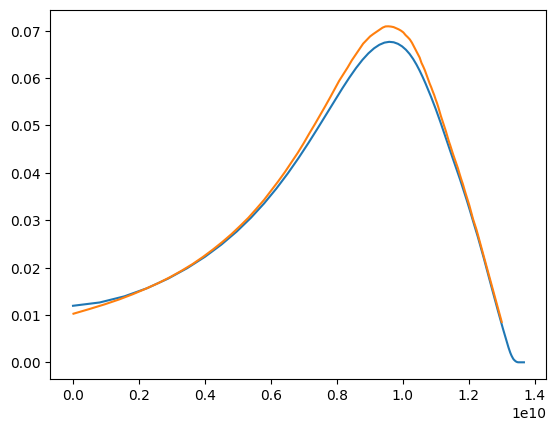

In [20]:
def get_csfrd_spline():

    csfrd_prior = gp.CSFRDPrior()
    csfrd_sample = csfrd_prior.sample_prior_corrected()
    redshifts = csfrd_prior.test_z
    lookback_times = cosmology.get_cosmology().lookback_time(redshifts).value*1e9
    csfrd_sample_spline = UnivariateSpline(lookback_times, csfrd_sample, s=0, ext=3)

    return lookback_times, csfrd_sample_spline

lbtimes, csfrdspl = get_csfrd_spline()
plt.plot(pb.tl_b19, pb.sfrd_b19)
plt.plot(lbtimes, csfrdspl(lbtimes))

In [21]:
def expe_logsfr_ratios_modified(this_z, this_m, logsfr_ratio_mini, logsfr_ratio_maxi,
                       nbins_sfh=7, amin=7.1295):
    """expectation values of logsfr_ratios
    """

    age_shifted = np.log10(pb.cosmo.age(this_z).value) + pb.delta_t_dex(this_m)
    age_shifted = 10**age_shifted

    zmin_thres = 0.15
    zmax_thres = 10
    if age_shifted < pb.age[-1]:
        z_shifted = zmax_thres * 1
    elif age_shifted > pb.age[0]:
        z_shifted = zmin_thres * 1
    else:
        z_shifted = pb.f_age_z(age_shifted)
    if z_shifted > zmax_thres:
        z_shifted = zmax_thres * 1
    if z_shifted < zmin_thres:
        z_shifted = zmin_thres * 1

    agebins_shifted = pb.z_to_agebins_rescale(zstart=z_shifted, nbins_sfh=nbins_sfh, amin=amin)

    nsfrbins = agebins_shifted.shape[0]
    sfr_shifted = np.zeros(nsfrbins)
    for i in range(nsfrbins):
        a = agebins_shifted[i,0]
        b = agebins_shifted[i,1]
        sfr_shifted[i] = get_csfrd_spline()[1].integral(a=a, b=b)/(b-a)

    logsfr_ratios_shifted = np.zeros(nsfrbins-1)
    with np.errstate(invalid='ignore', divide='ignore'):
        for i in range(nsfrbins-1):
            logsfr_ratios_shifted[i] = np.log10(sfr_shifted[i]/sfr_shifted[i+1])
    logsfr_ratios_shifted = np.clip(logsfr_ratios_shifted, logsfr_ratio_mini, logsfr_ratio_maxi)

    if not np.all(np.isfinite(logsfr_ratios_shifted)):
        # set nan accord. to its neighbor
        nan_idx = np.isnan(logsfr_ratios_shifted)
        finite_idx = np.min(np.where(nan_idx==True))-1
        neigh = logsfr_ratios_shifted[finite_idx]
        nan_idx = np.arange(6-finite_idx-1) + finite_idx + 1
        for i in range(len(nan_idx)):
            logsfr_ratios_shifted[nan_idx[i]] = neigh * 1.

    return logsfr_ratios_shifted

In [22]:
class ModifiedDymSFHfixZred(DymSFHfixZred):

    def __init__(self, parnames=[], name='', **kwargs):
        super().__init__(parnames=[], name='', **kwargs)

    def sample(self, nsample=None, **kwargs):
        """Draw a sample from the prior distribution.
        Needed for minimizer.

        :param nsample: (optional)
            Unused. Will not work if nsample > 1 in draw_sample()!
        """
        if len(kwargs) > 0:
            self.update(**kwargs)
        # draw a zred from pdf(z)
        zred = self.zred * 1

        mass = self.mass_dist.sample()

        # given mass from above, draw logzsol
        met_dist = priors.FastTruncatedNormal(a=self.params['z_mini'], b=self.params['z_maxi'],
                                                mu=pb.loc_massmet(mass), sig=pb.scale_massmet(mass))
        met = met_dist.sample()

        # sfh = sfrd
        logsfr_ratios = expe_logsfr_ratios_modified(this_z=zred, this_m=mass, nbins_sfh=self.params['nbins_sfh'],
                                            logsfr_ratio_mini=self.params['logsfr_ratio_mini'],
                                            logsfr_ratio_maxi=self.params['logsfr_ratio_maxi'])
        logsfr_ratios_rvs = t.rvs(df=2, loc=logsfr_ratios, scale=self.params['logsfr_ratio_tscale'])
        logsfr_ratios_rvs = np.clip(logsfr_ratios_rvs, a_min=self.params['logsfr_ratio_mini'], a_max=self.params['logsfr_ratio_maxi'])

        return np.concatenate([np.atleast_1d(zred), np.atleast_1d(mass),
                                np.atleast_1d(met), np.atleast_1d(logsfr_ratios_rvs)])

In [23]:
def modified_prospector_beta_sfh_prior(nsamples, redshift, logmass, sigma):
    """Samples log SFR ratios from prospector-beta prior (Wang et al. 2023).
    nbins restricted to nbins=7 for use with sfh.default_agebins().
    """
    logsfrratios_samples = np.empty((nsamples, 6))
    for n in range(nsamples):

        samples = ModifiedDymSFHfixZred(zred=redshift,
                mass_mini=logmass-1e-3, mass_maxi=logmass+1e-3,
                z_mini=-1.98, z_maxi=0.19,
                logsfr_ratio_mini=-5.0, logsfr_ratio_maxi=5.0,
                logsfr_ratio_tscale=sigma, nbins_sfh=7,
                const_phi=True).sample()
        
        logsfrratios = ts.nzsfh_to_logsfr_ratios(samples)
        logsfrratios_samples[n, :] = logsfrratios

    return logsfrratios_samples

Text(0.5, 0, '$t_{L}/t_{\\mathrm{univ}}$')

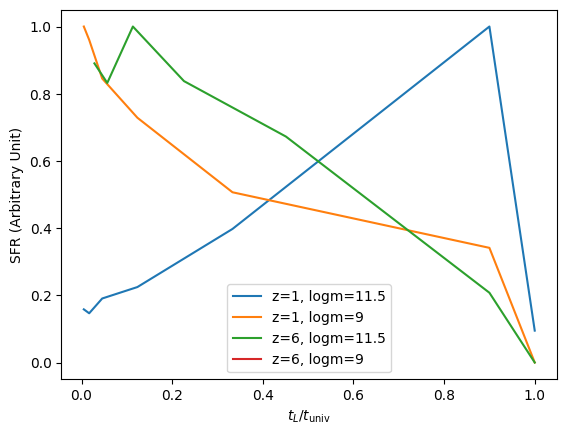

In [24]:
def get_sfr_curve(redshift, logmass):

    sigma = 0.000000000001
    agebins = sfh.default_agebins()

    logsfrratios = modified_prospector_beta_sfh_prior(10, redshift, logmass, sigma)[0, :]

    agebins_pbeta = ts.zred_to_agebins_pbeta(np.array([redshift]), agebins)
    sfrs = ts.logsfr_ratios_to_sfrs(logmass, logsfrratios, agebins_pbeta)
    lookback_time = (10**agebins_pbeta[:, 1])/1e9
    tuniv = cosmology.get_wmap9().age(redshift)

    return lookback_time/tuniv, sfrs


redshift = 1
logmass = 11.5
x1, y1 = get_sfr_curve(redshift, logmass)

redshift = 6
logmass = 11.5
x2, y2 = get_sfr_curve(redshift, logmass)

redshift = 1
logmass = 9
x3, y3 = get_sfr_curve(redshift, logmass)

redshift = 6
logmass = 9
x4, y4 = get_sfr_curve(redshift, logmass)

plt.plot(x1.value, y1/np.max(y1), label="z=1, logm=11.5")
plt.plot(x3.value, y3/np.max(y3), label="z=1, logm=9")
plt.plot(x2.value, y2/np.max(y2), label="z=6, logm=11.5")
plt.plot(x4.value, y4/np.max(y4), label="z=6, logm=9")
plt.legend()

plt.ylabel("SFR (Arbitrary Unit)")
plt.xlabel("$t_{L}/t_{\mathrm{univ}}$")